# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Defining-the-hypoxia-response" data-toc-modified-id="Defining-the-hypoxia-response-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Defining the hypoxia response</a></div><div class="lev2 toc-item"><a href="#Enrichment-analysis-of-the-hypoxia-response" data-toc-modified-id="Enrichment-analysis-of-the-hypoxia-response-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Enrichment analysis of the hypoxia response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-Global-HIF-1-response" data-toc-modified-id="Enrichment-Analysis-of-the-Global-HIF-1-response-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Enrichment Analysis of the Global HIF-1 response</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analyses-of-the-egl-9-transcriptome" data-toc-modified-id="Enrichment-Analyses-of-the-egl-9-transcriptome-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Enrichment Analyses of the <em>egl-9</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-vhl-1-transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-vhl-1-transcriptome-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Enrichment Analysis of the <em>vhl-1</em> transcriptome</a></div><div class="lev1 toc-item"><a href="#Enrichment-Analysis-of-the-hif-1--transcriptome" data-toc-modified-id="Enrichment-Analysis-of-the-hif-1--transcriptome-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Enrichment Analysis of the <em>hif-1</em>  transcriptome</a></div>

In this notebook, we will isolate the hypoxia response (defined as the set of genes commonly regulated by *egl-9*, *rhy-1* and *vhl-1*), and we will perform enrichment analysis on the hypoxia response. We will also perform enrichment analyses on each mutant transcriptomes, to try to understand how different each transcriptome actually is.

In [1]:
# important stuff:
import os
import pandas as pd

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan
import gvars
import epistasis as epi

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif',
              'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png','retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [2]:
q = 0.1
# this loads all the labels we need
genvar = gvars.genvars()

tissue_df = tea.fetch_dictionary()
phenotype_df = tea.fetch_dictionary('phenotype')
go_df = tea.fetch_dictionary('go')
respiratory_complexes = pd.read_excel('../input/respiratory_complexes.xlsx')

In [3]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']

# initialize the morgan.hunt object:
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')
thomas.add_single_mutant(single_mutants)
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
sleuth_loc = '../sleuth/kallisto/'

thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')
# load beta dataframes:
for file in os.listdir("../sleuth/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)
thomas.filter_data()

In [4]:
# tidy up and clean out
frames = []
for key, df in thomas.beta.items():
    df['genotype'] = genvar.mapping[key]
    df['code'] = key
    frames += [df]
    df['sorter'] = genvar.sort_muts[key]
tidy = pd.concat(frames)
tidy.sort_values('sorter', inplace=True)
tidy.dropna(subset=['ens_gene'], inplace=True)

# Defining the hypoxia response

We defined the hypoxia response as the set of genes that change in the same direction in mutants of *egl-9*, *vhl-1* and *rhy-1*. We use `epi.find_overlap` from the `epistasis` module that we wrote. This function finds genes that are statistically significantly altered in common between $n$ genotypes. However, `find_overlap` is direction agnostic. Therefore, I will call it twice: Once with a sliced list of genes that have positive $\beta$s and once with negative $\beta$s. 

In [5]:
# find the genes that change in the same direction in all mutants with 
# a constitutive hypoxia response
hyp_response_pos = epi.find_overlap(['e', 'b', 'a', 'd'], tidy[tidy.b > 0])
hyp_response_neg = epi.find_overlap(['e', 'b', 'a', 'd'], tidy[tidy.b < 0])

In [6]:
# now, find the genes that are in hyp_response_pos AND either change in the 
# opposite direction or do not change at all in the 'f' mutant (the egl;hif double)
# Technically, we should also gate on the 'c' mutant (hif-1) but the results
# don't change much
either_or = (((tidy.b < 0) & (tidy.qval < q)) | (tidy.qval > q))
hyp_response_pos = tidy[(tidy.target_id.isin(hyp_response_pos)) & (tidy.code == 'f') & either_or].target_id.values.tolist()

# do the same for the negative set
either_or = ((tidy.b > 0) & (tidy.qval < q)) | (tidy.qval > q)
hyp_response_neg = tidy[(tidy.target_id.isin(hyp_response_neg)) & (tidy.code == 'f') & either_or].target_id.values.tolist()

# get the list
hyp_response = list(set(hyp_response_neg + hyp_response_pos))

In [7]:
# slice out the genes we found, using the egl-9 betas
hyp = tidy[(tidy.target_id.isin(hyp_response)) &
           (tidy.code == 'b')
          ].copy().sort_values('qval')

# annotate whether they are candidates for direct or
# indirect regulation.
def annotate(x):
    if x > 0:
        return 'candidate for direct regulation'
    else:
        return 'candidate for indirect regulation'

# annotate
hyp['regulation'] = hyp.b.apply(annotate)

In [8]:
# save to file
cols = ['target_id', 'ens_gene', 'ext_gene', 'b', 'qval', 'regulation']
hyp[cols].to_csv('../output/hypoxia_response.csv', index=False)

# get the list of gene IDs as a numpy array.
hyp_response = tidy[tidy.target_id.isin(hyp_response)].ens_gene.unique()
print('There are {0} genes in the predicted hypoxia response'.format(len(hyp_response)))

There are 466 genes in the predicted hypoxia response


## Enrichment analysis of the hypoxia response

In [9]:
tea.enrichment_analysis(hyp.ens_gene.unique(), tissue_df=go_df, show=False)

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
200,developmental process GO:0032502,45.508138,157,3.449932,3.512929e-40,1.067930e-37
58,embryo development GO:0009790,26.477316,103,3.890122,5.002718e-31,7.604132e-29
217,post-embryonic development GO:0009791,18.990571,80,4.212617,9.891222e-27,1.002310e-24
19,reproduction GO:0000003,25.471033,85,3.337124,1.177056e-21,8.945624e-20
42,aging GO:0007568,7.720203,42,5.440272,5.452993e-19,3.315420e-17
26,reproductive system development GO:0061458,8.138816,42,5.160456,3.708263e-18,1.878853e-16
139,cytoplasm GO:0005737,64.869022,142,2.189026,8.771432e-18,3.809308e-16
204,development of primary sexual characteristics ...,8.018062,41,5.113455,1.221671e-17,4.642351e-16
214,immune system process GO:0002376,2.777341,24,8.641359,2.492592e-16,8.419422e-15
86,mitochondrion GO:0005739,9.515411,37,3.888429,1.725981e-12,5.246981e-11


# Enrichment Analysis of the Global HIF-1 response

Now that we have found the hypoxia response, we can perform tissue, phenotype and gene ontology enrichment analysis on this gene battery.
Note that we don't show all possibilities. When a particular analysis is not present, it is because the enrichment results were empty.

In [10]:
teaH = tea.enrichment_analysis(hyp_response, tissue_df, show=False)
geaH = tea.enrichment_analysis(hyp_response, go_df, show=False)

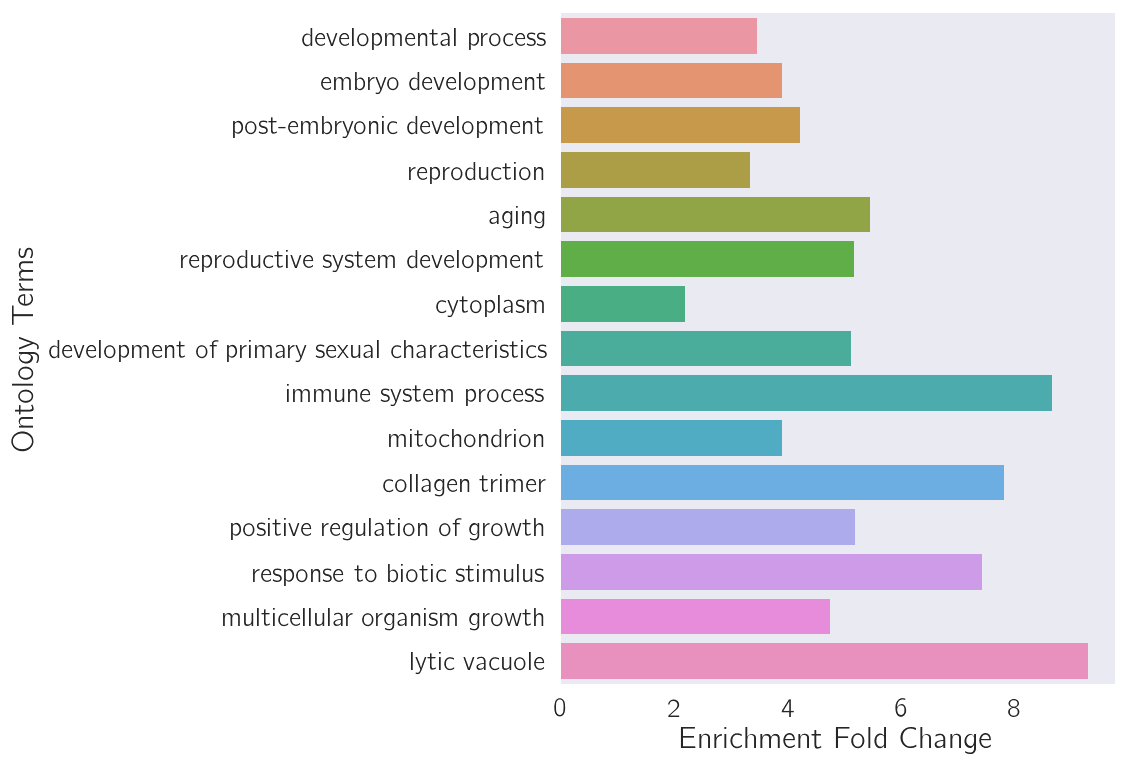

In [11]:
tea.plot_enrichment_results(geaH, analysis='go')
plt.savefig('../output/hypoxia_response_gea.svg', bbox_inches='tight')

In [12]:
teaH

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
40,intestine WBbt:0005772,163.269413,265,1.623084,5.527001e-15,1.519925e-12
14,epithelial system WBbt:0005730,111.377367,157,1.409622,9.162358e-06,1.259824e-03
110,anal depressor muscle WBbt:0004292,13.001031,29,2.230592,2.627952e-05,2.408956e-03
149,muscular system WBbt:0005737,140.909881,183,1.298702,1.663351e-04,1.071035e-02
7,cephalic sheath cell WBbt:0008406,8.489897,20,2.355741,1.557869e-04,1.071035e-02
107,hermaphrodite WBbt:0007849,66.238011,96,1.449319,1.591782e-04,1.071035e-02


These enrichment analyses show, as expected, that the HIF-dependent hypoxia response causes important changes in metabolism and physiology relating to oxygen availability. Tissue enrichment shows enrichment in the cephalic sheath cells (strange) but also in the uterine seam cells. Again, no idea what it means, although reports by [Chang and Bargmann](http://www.pnas.org/content/105/20/7321.full) suggest that the somatic gonad plays a special role in modulating behavior during hypoxia.

# Enrichment Analyses of the *egl-9* transcriptome

In [13]:
egl = tidy[(tidy.qval < q) & (tidy.code == 'e')]
teaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), tissue_df, show=False)
peaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), phenotype_df, show=False)
geaEgl = tea.enrichment_analysis(egl[egl.qval < q].ens_gene.unique(), go_df, show=False)

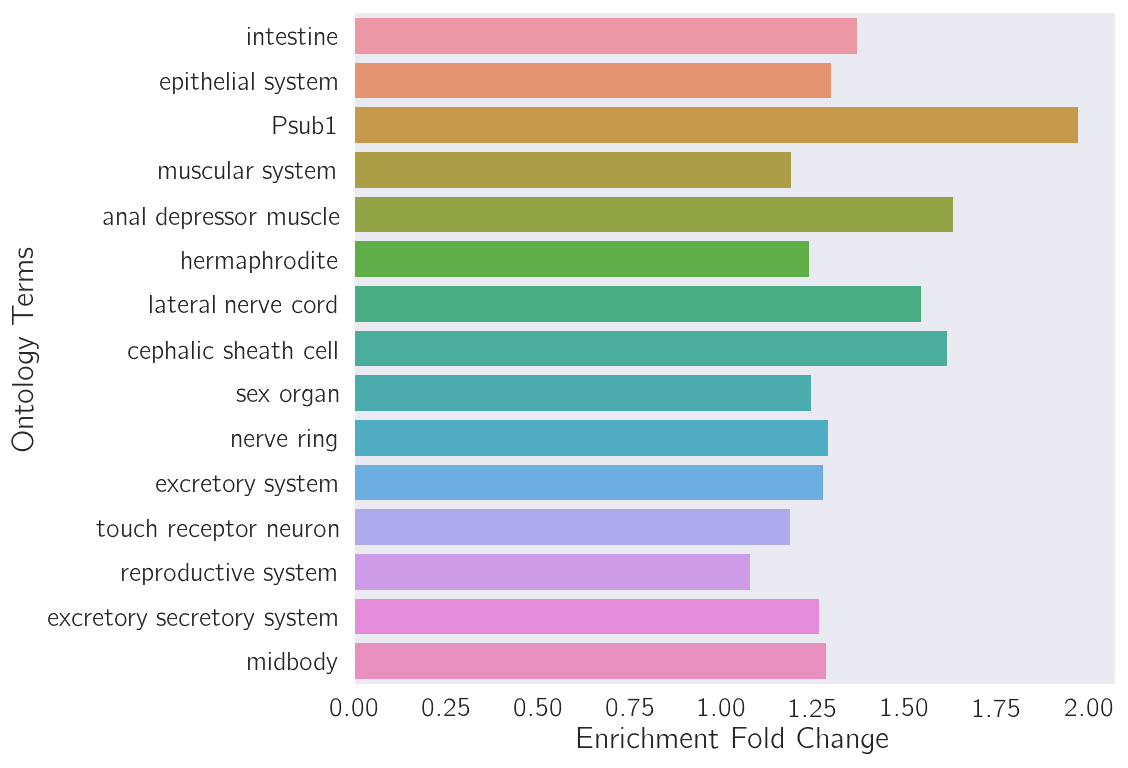

In [14]:
tea.plot_enrichment_results(teaEgl)

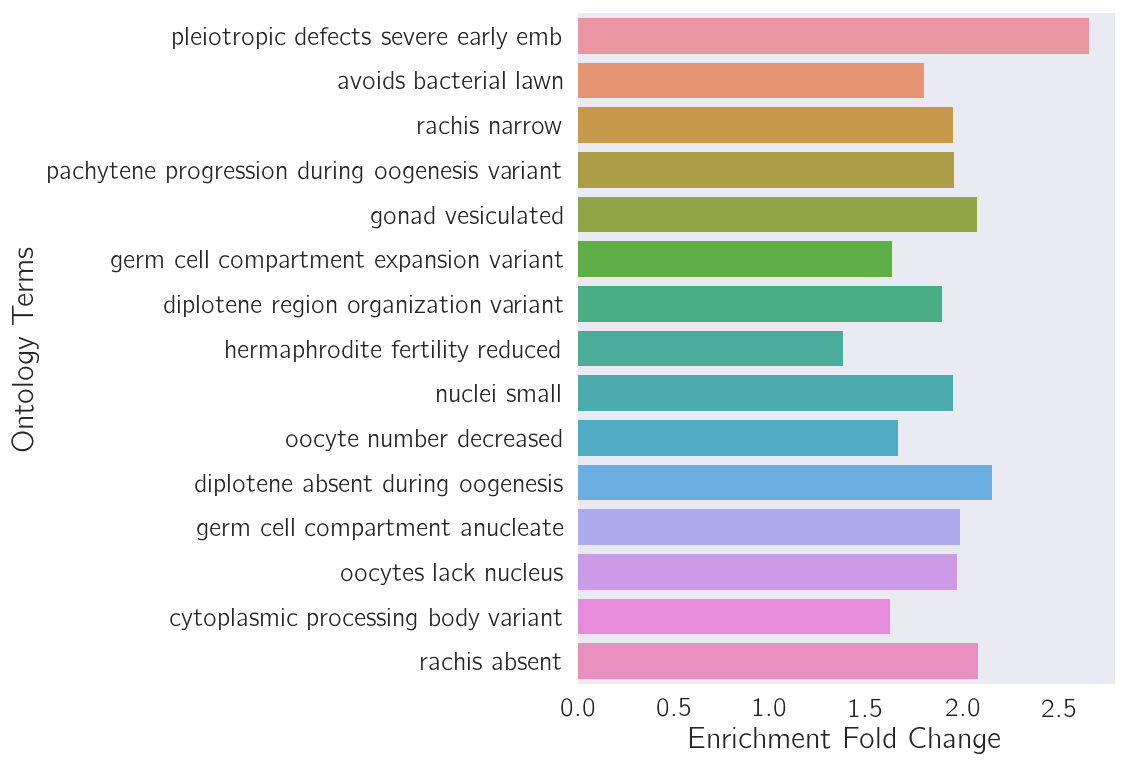

In [15]:
tea.plot_enrichment_results(peaEgl, analysis='phenotype')

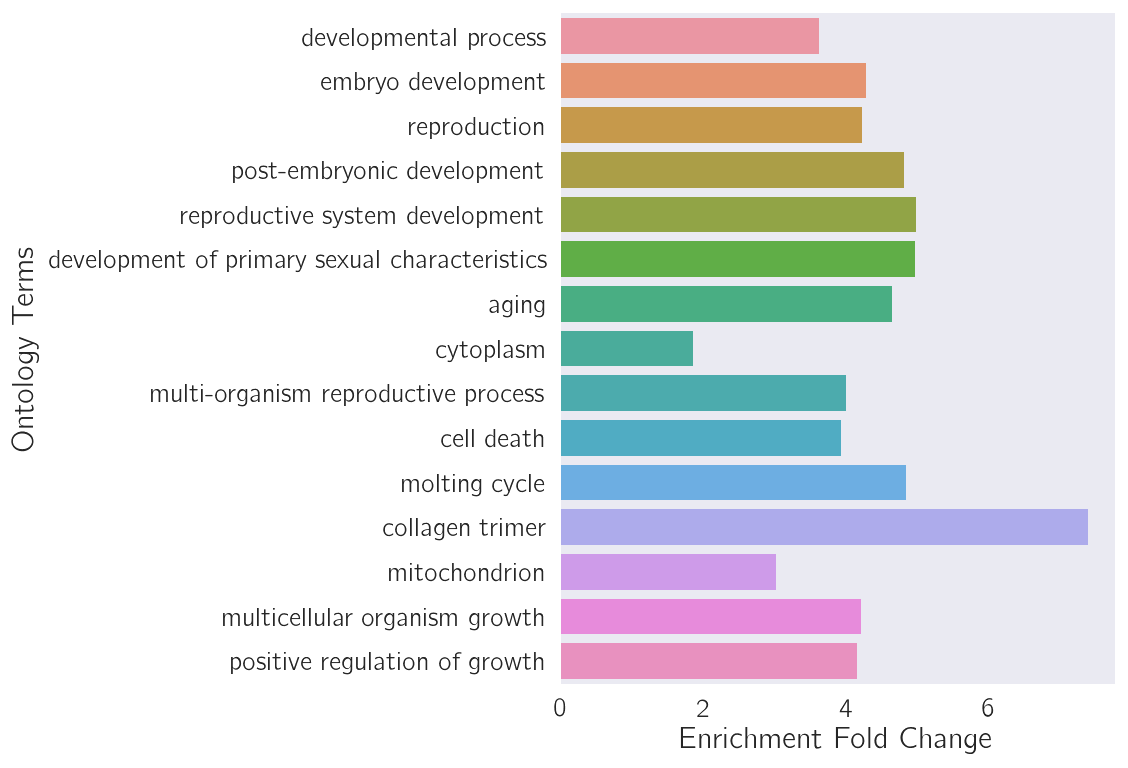

In [16]:
tea.plot_enrichment_results(geaEgl, analysis='go')

# Enrichment Analysis of the *vhl-1* transcriptome

In [17]:
vhl = tidy[(tidy.qval < q) & (tidy.code == 'd')]
teaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geaVhl = tea.enrichment_analysis(vhl[vhl.qval < 0.1].ens_gene.unique(), go_df, show=False)

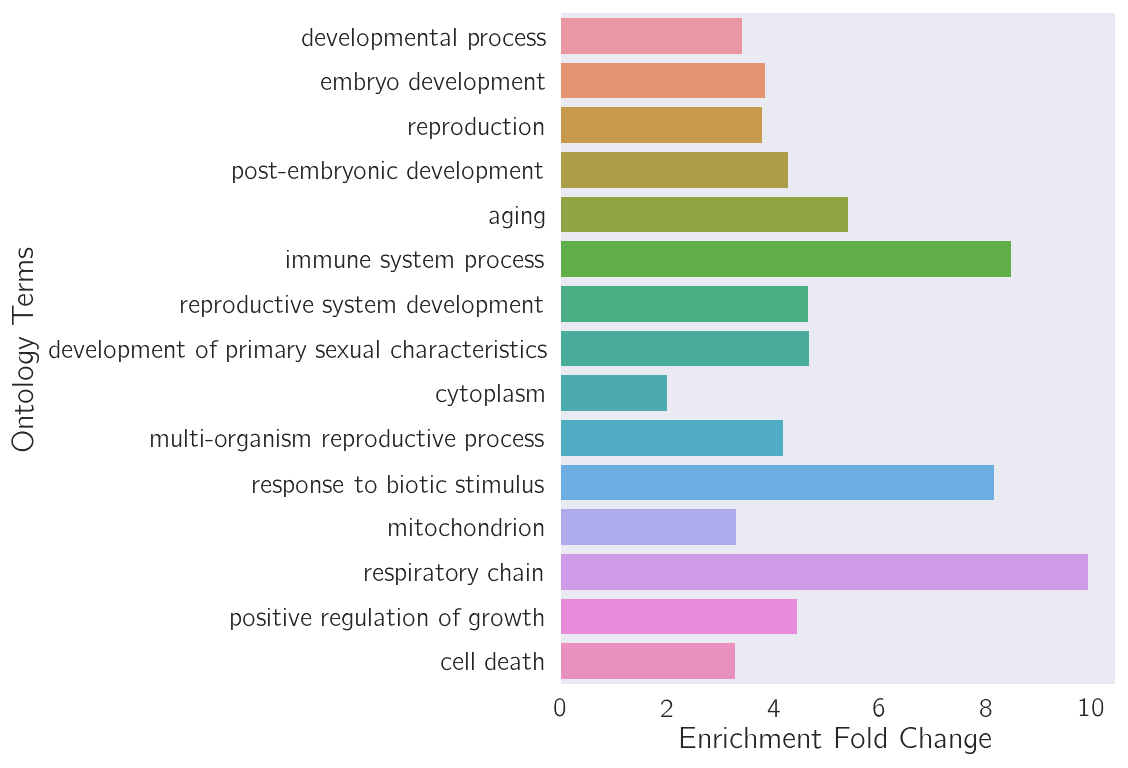

In [18]:
tea.plot_enrichment_results(geaVhl, analysis='go')

In [19]:
teaVhl

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
236,intestine WBbt:0005772,464.150012,703,1.514597,2.039739e-29,5.609282e-27
7,cephalic sheath cell WBbt:0008406,24.135482,53,2.195937,2.123744e-08,2.920148e-06
91,anal depressor muscle WBbt:0004292,36.959946,68,1.839830,4.401910e-07,4.035084e-05
125,muscular system WBbt:0005737,400.585277,490,1.223210,1.544348e-06,1.061739e-04
11,epithelial system WBbt:0005730,316.628848,386,1.219093,2.474992e-05,1.361245e-03
225,hermaphrodite WBbt:0007849,188.304553,241,1.279842,4.010707e-05,1.838241e-03
68,pm7 WBbt:0003721,3.106547,9,2.897107,7.539761e-04,2.962049e-02
189,pm3 WBbt:0003740,3.186202,9,2.824679,9.341683e-04,3.211203e-02
86,anal sphincter muscle WBbt:0005798,10.355157,20,1.931405,1.473050e-03,4.500985e-02
152,PVD WBbt:0006831,230.521732,273,1.184270,1.721967e-03,4.735409e-02


# Enrichment Analysis of the *hif-1*  transcriptome

In [20]:
hif = tidy[(tidy.qval < q) & (tidy.code == 'c')]
teahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), tissue_df, show=False)
peahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), phenotype_df, show=False)
geahif = tea.enrichment_analysis(hif[hif.qval < 0.1].ens_gene.unique(), go_df, show=False)

In [21]:
teahif

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
210,intestine WBbt:0005772,389.926434,589,1.510541,2.420670e-24,6.656841e-22
112,muscular system WBbt:0005737,336.526521,408,1.212386,2.549480e-05,3.505536e-03
137,PVD WBbt:0006831,193.658332,239,1.234132,3.944955e-04,3.616209e-02


In [22]:
peahif

,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
1,pathogen susceptibility increased WBPhenotype:...,13.25852,30,2.262696,0.000008,0.001735


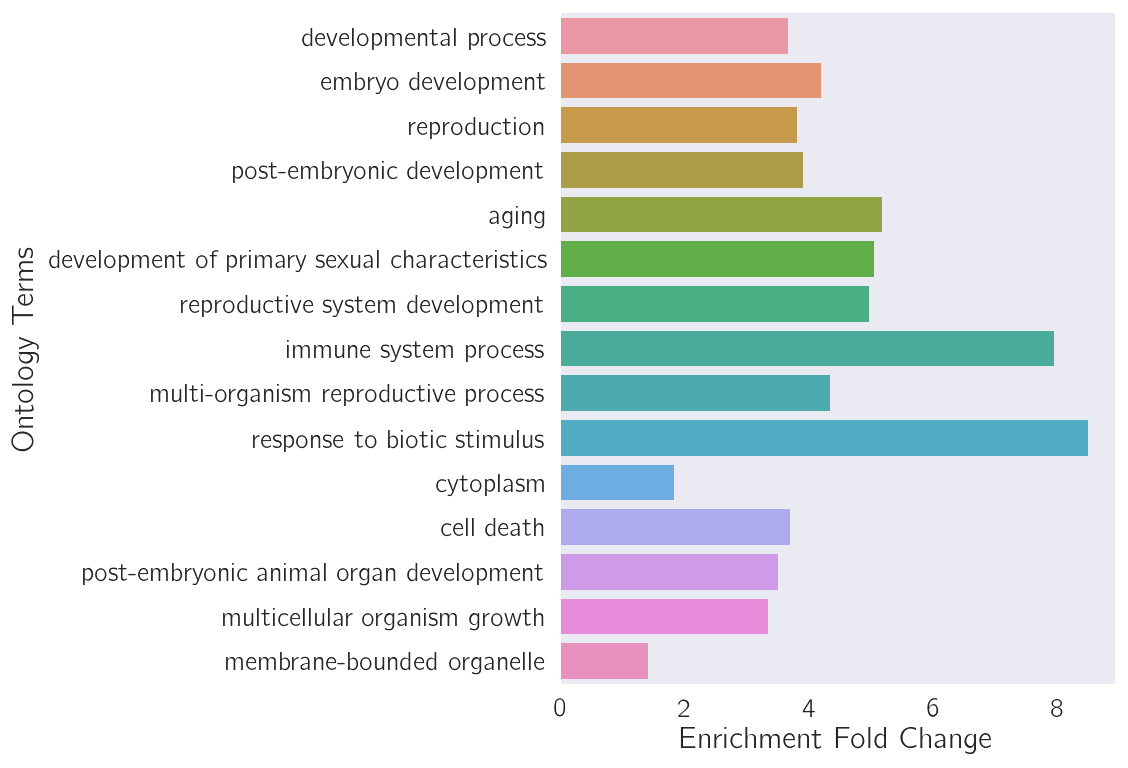

In [23]:
tea.plot_enrichment_results(geahif, analysis='go')

Many terms later, a conclusion is not to be had from enrichment analysis. The transcriptomic results reflect the known involvement of the hypoxic response in the immune response. On the other hand, the transcriptome results from *hif-1* suggest that HIF-1 regulates chaperones tightly even under normoxic conditions.